<a href="https://colab.research.google.com/github/mforker/Machine_learning/blob/main/Predicting_the_podcast_listening_time_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Podcast Listening Time - Kaggle

This notebook provides a detailed walkthrough of the code used to predict podcast listening time from the given dataset.

## 1. Importing Libraries

The following Python libraries are essential for this analysis:

- `pandas (pd)`: For data manipulation and handling.
- `numpy (np)`: For numerical computations.
- `matplotlib.pyplot (plt)`: For data visualization.
- `seaborn (sns)`: For enhanced data visualization.
- `xgboost (XGBRegressor)`: For implementing the XGBoost regression model.
- `sklearn.model_selection`: For splitting the data into training and testing sets.
- `sklearn.preprocessing`: For encoding categorical features and scaling numerical features.
- `sklearn.metrics`: For evaluating the model's performance.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import root_mean_squared_error


## 2. Loading the Data

The code loads the training and testing datasets from CSV files into pandas DataFrames.

In [ ]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print(df.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB



## 3. Initial Data Inspection

The code prints the information (data types and non-null counts) and shape (number of rows and columns) of the training and testing sets. This step helps in understanding the structure of the data and identifying potential issues like missing values.


In [ ]:
print(df.shape)
print(df_test.shape)

(750000, 12)
(250000, 11)


In [ ]:
print('--------------train data----------')
print(df.isna().sum())
print('--------------test data------------')
print(df_test.isna().sum())

--------------train data----------
id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64
--------------test data------------
id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64


In [ ]:
df = df[~df['Number_of_Ads'].isna()]
print('train data shape:',df.shape)

df_test = df_test[~df_test['Number_of_Ads'].isna()]
print('test data shape:',df_test.shape)

train data shape: (749999, 12)
test data shape: (250000, 11)


## 4. Handling Duplicates

Duplicate rows are removed from both the training and testing sets to ensure data integrity.


In [ ]:
df = df.drop_duplicates()
df_test = df_test.drop_duplicates()
print(df.shape)
print(df_test.shape)

(750000, 12)
(250000, 11)


## 6. Outlier Detection and Removal

Box plots are used to visualize the distribution of `Episode_Length_minutes` and `Number_of_Ads` in the training data, helping to identify potential outliers. Outliers are removed using the IQR method.


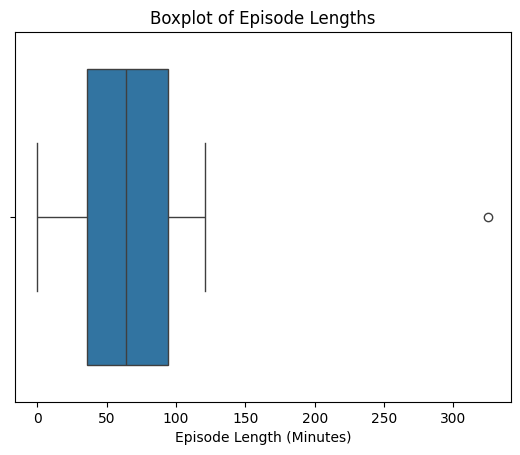

In [ ]:
#plotting outliers for train data
sns.boxplot(x = df['Episode_Length_minutes'])
plt.xlabel('Episode Length (Minutes)')
plt.title('Boxplot of Episode Lengths')
plt.show()

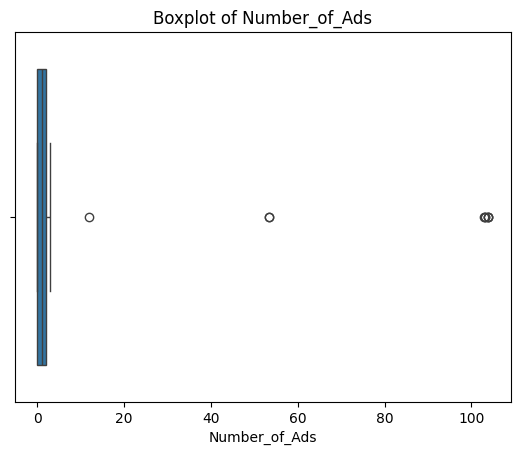

In [ ]:
#plotting outliers for train data
sns.boxplot(x = df['Number_of_Ads'])
plt.xlabel('Number_of_Ads')
plt.title('Boxplot of Number_of_Ads')
plt.show()

In [ ]:
# removing outliers for train data
q1 = df['Episode_Length_minutes'].quantile(0.25)
q3 = df['Episode_Length_minutes'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df_nan = df[df['Episode_Length_minutes'].isna()]
df = df[~df['Episode_Length_minutes'].isna()]
df = df[(df['Episode_Length_minutes'] >= lower_bound) & (df['Episode_Length_minutes'] <= upper_bound)]
df = pd.concat([df,df_nan])
print(df.shape)

(749998, 12)


In [ ]:
# removing outliers for train data
q1 = df['Number_of_Ads'].quantile(0.25)
q3 = df['Number_of_Ads'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df_nan = df[df['Number_of_Ads'].isna()]
df = df[~df['Number_of_Ads'].isna()]
df = df[(df['Number_of_Ads'] >= lower_bound) & (df['Number_of_Ads'] <= upper_bound)]
df = pd.concat([df,df_nan])
print(df.shape)

(749989, 12)


## 7. Imputing Missing Values

Missing values in `Episode_Length_minutes` are imputed using the mean episode length for each podcast, and missing values in `Guest_Popularity_percentage` are imputed using the mean popularity for each genre. This is done for both the training and test sets.


In [ ]:
# imputing Episode Length Minutes train data
mean_len = df.groupby('Podcast_Name')['Episode_Length_minutes'].mean().reset_index(name = 'Mean_Dur')
mean_len_map = mean_len.set_index('Podcast_Name')['Mean_Dur'].to_dict()
mean_len_map


{"Athlete's Arena": 65.84145002666152,
 'Brain Boost': 63.45841916371799,
 'Business Briefs': 66.67273117600233,
 'Business Insights': 62.85052578646617,
 'Comedy Corner': 62.63415984873937,
 'Crime Chronicles': 66.09306282286539,
 'Criminal Minds': 61.44970857441532,
 'Current Affairs': 62.01022120059374,
 'Daily Digest': 65.28976221517944,
 'Detective Diaries': 65.83168232027475,
 'Digital Digest': 63.4173656755638,
 'Educational Nuggets': 65.06675002035371,
 'Fashion Forward': 64.62641731163349,
 'Finance Focus': 62.0513269868116,
 'Fitness First': 65.38452896585173,
 'Funny Folks': 63.73354234956822,
 'Gadget Geek': 65.03048366346326,
 'Game Day': 62.7135723936742,
 'Global News': 65.77577336517001,
 'Health Hour': 64.41884199562652,
 'Healthy Living': 64.53538735710995,
 'Home & Living': 66.50949387549903,
 'Humor Hub': 65.41717706239568,
 'Innovators': 64.52611539726462,
 'Joke Junction': 61.348252092201896,
 'Laugh Line': 63.03206505745214,
 'Learning Lab': 65.2761204178481,
 'L

In [ ]:
# imputing Guest_Popularity_percentage train data
pop_rating_gener = df.groupby('Genre')['Guest_Popularity_percentage'].mean().reset_index(name = 'Mean_Pop')
rating_map = pop_rating_gener.set_index('Genre')['Mean_Pop'].to_dict()
rating_map

{'Business': 51.22199563894205,
 'Comedy': 53.36126372340106,
 'Education': 52.3152052570545,
 'Health': 51.441465000343804,
 'Lifestyle': 51.757591048236094,
 'Music': 52.054404132064754,
 'News': 52.43683772161711,
 'Sports': 53.077234609328485,
 'Technology': 51.83673721373768,
 'True Crime': 52.714811690746025}

In [ ]:
df.loc[df['Guest_Popularity_percentage'].isna(),'Guest_Popularity_percentage'] = (df.loc[df['Guest_Popularity_percentage'].isna(),'Genre'].map(rating_map))
print(df.isna().sum())

id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         87093
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage        0
Number_of_Ads                      0
Episode_Sentiment                  0
Listening_Time_minutes             0
dtype: int64


In [ ]:
df.loc[df['Episode_Length_minutes'].isna(),'Episode_Length_minutes'] = (df.loc[df['Episode_Length_minutes'].isna(),'Podcast_Name'].map(mean_len_map))
print(df.isna().sum())
df.loc[df['Podcast_Name']=='Music Matters',:]

id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
dtype: int64


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
38,38,Music Matters,Episode 32,86.840000,Music,86.65,Thursday,Morning,28.270000,1.0,Neutral,81.49839
64,64,Music Matters,Episode 69,81.130000,Music,66.37,Wednesday,Evening,97.430000,1.0,Negative,55.97010
85,85,Music Matters,Episode 23,9.730000,Music,31.68,Tuesday,Morning,52.060000,1.0,Neutral,6.01368
127,127,Music Matters,Episode 59,64.570000,Music,84.75,Thursday,Morning,52.054404,1.0,Neutral,53.49181
209,209,Music Matters,Episode 21,85.180000,Music,85.61,Wednesday,Evening,96.450000,1.0,Neutral,73.71758
...,...,...,...,...,...,...,...,...,...,...,...,...
745564,745564,Music Matters,Episode 45,65.192867,Music,71.76,Tuesday,Night,33.560000,2.0,Negative,97.47198
745642,745642,Music Matters,Episode 69,65.192867,Music,23.22,Sunday,Afternoon,18.900000,0.0,Negative,66.61818
748086,748086,Music Matters,Episode 85,65.192867,Music,41.10,Saturday,Afternoon,79.400000,0.0,Positive,91.31101
749364,749364,Music Matters,Episode 34,65.192867,Music,76.19,Friday,Morning,99.080000,3.0,Positive,51.55510


In [ ]:
# imputing Episode Length Minutes test data
test_mean_len = df_test.groupby('Podcast_Name')['Episode_Length_minutes'].mean().reset_index(name = 'Mean_Dur')
test_mean_len_map = test_mean_len.set_index('Podcast_Name')['Mean_Dur'].to_dict()
test_mean_len_map

{"Athlete's Arena": 65.12400223990402,
 'Brain Boost': 63.55702779197694,
 'Business Briefs': 66.73816472337504,
 'Business Insights': 62.53988221420274,
 'Comedy Corner': 63.11928717586774,
 'Crime Chronicles': 65.9042661971855,
 'Criminal Minds': 61.119463578531416,
 'Current Affairs': 64.11785059557535,
 'Daily Digest': 65.47994189256232,
 'Detective Diaries': 66.18937561614567,
 'Digital Digest': 62.77205851416113,
 'Educational Nuggets': 64.17391255298105,
 'Fashion Forward': 64.35771060252483,
 'Finance Focus': 62.35637068779561,
 'Fitness First': 66.1003914756141,
 'Funny Folks': 63.6383543978125,
 'Gadget Geek': 64.93357723912322,
 'Game Day': 62.70095211626103,
 'Global News': 65.58818986538334,
 'Health Hour': 63.28424440501039,
 'Healthy Living': 65.03355382776243,
 'Home & Living': 66.23382526629666,
 'Humor Hub': 65.92613874577283,
 'Innovators': 66.35921274283481,
 'Joke Junction': 61.4982957730889,
 'Laugh Line': 63.28202952327669,
 'Learning Lab': 65.86662320897504,
 'L

In [ ]:
# imputing Guest_Popularity_percentage test data
test_pop_rating_gener = df_test.groupby('Genre')['Guest_Popularity_percentage'].mean().reset_index(name = 'Mean_Pop')
test_rating_map = test_pop_rating_gener.set_index('Genre')['Mean_Pop'].to_dict()
test_rating_map

{'Business': 51.37693447293447,
 'Comedy': 53.15304508484497,
 'Education': 52.10616224529027,
 'Health': 51.406536136187775,
 'Lifestyle': 52.0630732202791,
 'Music': 51.90412944073162,
 'News': 52.46579460801703,
 'Sports': 53.058590066426426,
 'Technology': 51.55843806994245,
 'True Crime': 52.61235182058276}

In [ ]:
df_test.loc[df_test['Guest_Popularity_percentage'].isna(),'Guest_Popularity_percentage'] = (df_test.loc[df_test['Guest_Popularity_percentage'].isna(),'Genre'].map(test_rating_map))
print(df_test.isna().sum())

id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage        0
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64


In [ ]:
df_test.loc[df_test['Episode_Length_minutes'].isna(),'Episode_Length_minutes'] = (df_test.loc[df_test['Episode_Length_minutes'].isna(),'Podcast_Name'].map(test_mean_len_map))
print(df_test.isna().sum())
df_test.loc[df_test['Podcast_Name']=='Music Matters',:]

id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
dtype: int64


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
88,750088,Music Matters,Episode 25,20.32000,Music,94.12,Thursday,Evening,51.904129,2.0,Positive
119,750119,Music Matters,Episode 75,34.97000,Music,84.58,Tuesday,Morning,92.240000,1.0,Positive
149,750149,Music Matters,Episode 38,12.87000,Music,28.38,Monday,Evening,66.930000,0.0,Neutral
154,750154,Music Matters,Episode 33,78.22000,Music,88.07,Tuesday,Night,51.904129,1.0,Negative
168,750168,Music Matters,Episode 75,72.02000,Music,96.93,Thursday,Afternoon,82.410000,0.0,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
249768,999768,Music Matters,Episode 51,6.89000,Music,64.30,Wednesday,Morning,55.460000,3.0,Neutral
249772,999772,Music Matters,Episode 32,23.16000,Music,56.57,Friday,Evening,7.290000,3.0,Negative
249863,999863,Music Matters,Episode 68,89.33000,Music,36.31,Wednesday,Evening,62.980000,3.0,Positive
249877,999877,Music Matters,Episode 69,64.84329,Music,98.26,Monday,Morning,34.520000,2.0,Negative


## 8. Feature Selection

The code removes the `Episode_Title` and `id` columns from both the training and testing sets, as these columns are not needed for the model.


In [ ]:
cols = list(df.columns)
cols.remove('Episode_Title')
cols.remove('id')
df = df.loc[:,cols]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 749989 entries, 1 to 749984
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 749989 non-null  object 
 1   Episode_Length_minutes       749989 non-null  float64
 2   Genre                        749989 non-null  object 
 3   Host_Popularity_percentage   749989 non-null  float64
 4   Publication_Day              749989 non-null  object 
 5   Publication_Time             749989 non-null  object 
 6   Guest_Popularity_percentage  749989 non-null  float64
 7   Number_of_Ads                749989 non-null  float64
 8   Episode_Sentiment            749989 non-null  object 
 9   Listening_Time_minutes       749989 non-null  float64
dtypes: float64(5), object(5)
memory usage: 62.9+ MB


In [ ]:
cols = list(df_test.columns)
cols.remove('Episode_Title')
cols.remove('id')
df_test = df_test.loc[:,cols]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 9 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 250000 non-null  object 
 1   Episode_Length_minutes       250000 non-null  float64
 2   Genre                        250000 non-null  object 
 3   Host_Popularity_percentage   250000 non-null  float64
 4   Publication_Day              250000 non-null  object 
 5   Publication_Time             250000 non-null  object 
 6   Guest_Popularity_percentage  250000 non-null  float64
 7   Number_of_Ads                250000 non-null  float64
 8   Episode_Sentiment            250000 non-null  object 
dtypes: float64(4), object(5)
memory usage: 17.2+ MB


## 9. Categorical Feature Encoding

Categorical features (`Genre`, `Podcast_Name`, `Publication_Day`, `Publication_Time`, and `Episode_Sentiment`) in both the training and testing sets are encoded using Label Encoding, converting them into numerical values.


In [ ]:
encoder = LabelEncoder()
df.loc[:,'Genre'] = encoder.fit_transform(df.loc[:,'Genre'])
df.loc[:,'Podcast_Name'] = encoder.fit_transform(df.loc[:,'Podcast_Name'])
df.loc[:,'Publication_Day'] = encoder.fit_transform(df.loc[:,'Publication_Day'])
df.loc[:,'Publication_Time'] = encoder.fit_transform(df.loc[:,'Publication_Time'])
df.loc[:,'Episode_Sentiment'] = encoder.fit_transform(df.loc[:,'Episode_Sentiment'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 749989 entries, 1 to 749984
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 749989 non-null  object 
 1   Episode_Length_minutes       749989 non-null  float64
 2   Genre                        749989 non-null  object 
 3   Host_Popularity_percentage   749989 non-null  float64
 4   Publication_Day              749989 non-null  object 
 5   Publication_Time             749989 non-null  object 
 6   Guest_Popularity_percentage  749989 non-null  float64
 7   Number_of_Ads                749989 non-null  float64
 8   Episode_Sentiment            749989 non-null  object 
 9   Listening_Time_minutes       749989 non-null  float64
dtypes: float64(5), object(5)
memory usage: 62.9+ MB


In [ ]:
df_test.loc[:,'Genre'] = encoder.fit_transform(df_test.loc[:,'Genre'])
df_test.loc[:,'Podcast_Name'] = encoder.fit_transform(df_test.loc[:,'Podcast_Name'])
df_test.loc[:,'Publication_Day'] = encoder.fit_transform(df_test.loc[:,'Publication_Day'])
df_test.loc[:,'Publication_Time'] = encoder.fit_transform(df_test.loc[:,'Publication_Time'])
df_test.loc[:,'Episode_Sentiment'] = encoder.fit_transform(df_test.loc[:,'Episode_Sentiment'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 9 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 250000 non-null  object 
 1   Episode_Length_minutes       250000 non-null  float64
 2   Genre                        250000 non-null  object 
 3   Host_Popularity_percentage   250000 non-null  float64
 4   Publication_Day              250000 non-null  object 
 5   Publication_Time             250000 non-null  object 
 6   Guest_Popularity_percentage  250000 non-null  float64
 7   Number_of_Ads                250000 non-null  float64
 8   Episode_Sentiment            250000 non-null  object 
dtypes: float64(4), object(5)
memory usage: 17.2+ MB


## 10. Data Type Conversion

The code ensures all columns in both the training and testing sets are of numeric data types.


In [ ]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 749989 entries, 1 to 749984
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 749989 non-null  int64  
 1   Episode_Length_minutes       749989 non-null  float64
 2   Genre                        749989 non-null  int64  
 3   Host_Popularity_percentage   749989 non-null  float64
 4   Publication_Day              749989 non-null  int64  
 5   Publication_Time             749989 non-null  int64  
 6   Guest_Popularity_percentage  749989 non-null  float64
 7   Number_of_Ads                749989 non-null  float64
 8   Episode_Sentiment            749989 non-null  int64  
 9   Listening_Time_minutes       749989 non-null  float64
dtypes: float64(5), int64(5)
memory usage: 62.9 MB


In [ ]:
for col in df_test.columns:
    if df_test[col].dtype == 'object':
        df_test[col] = df_test[col].astype('int')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 9 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 250000 non-null  int64  
 1   Episode_Length_minutes       250000 non-null  float64
 2   Genre                        250000 non-null  int64  
 3   Host_Popularity_percentage   250000 non-null  float64
 4   Publication_Day              250000 non-null  int64  
 5   Publication_Time             250000 non-null  int64  
 6   Guest_Popularity_percentage  250000 non-null  float64
 7   Number_of_Ads                250000 non-null  float64
 8   Episode_Sentiment            250000 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 17.2 MB


## 11. Model Training and Evaluation

An XGBoost Regressor model is trained on the training data to predict the `Listening_Time_minutes`. The model's performance is evaluated using Root Mean Squared Error (RMSE) on the test set.


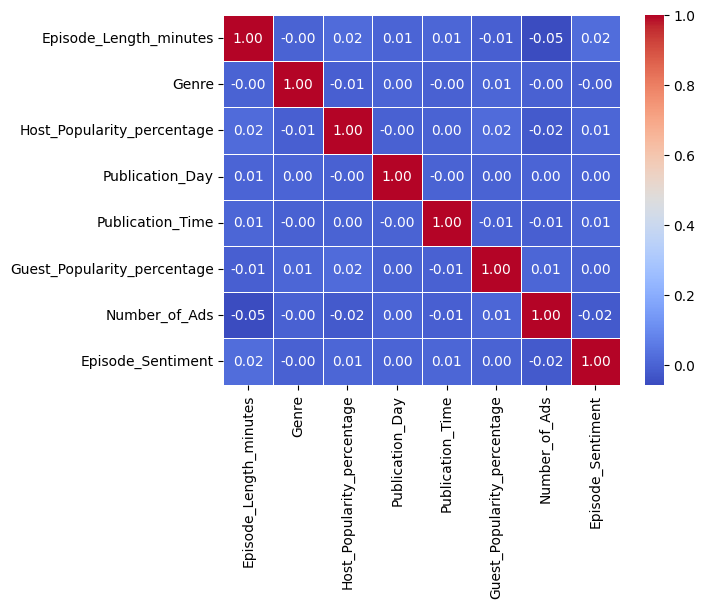

In [ ]:
features, target = df.drop(['Listening_Time_minutes','Podcast_Name'], axis=1), df['Listening_Time_minutes']
cm = features.corr()
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

In [ ]:
features, target = df.drop(['Listening_Time_minutes','Podcast_Name'], axis=1), df['Listening_Time_minutes']
# features = MinMaxScaler().fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
model_xgb = XGBRegressor(n_estimators = 265, learning_rate = 0.02, max_depth  = 7, gamma = 0)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)

In [ ]:
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.2f}")

Root Mean Squared Error: 13.08


## 12. Prediction on Test Set

The trained model is used to predict the listening times for the test set. The predictions are added as a new column to the test set DataFrame.









In [ ]:
df_test_pred = df_test.drop(['Podcast_Name'], axis=1)
predictions_on_testset = model_xgb.predict(df_test_pred)
print(predictions_on_testset)
df_test['Listening_Time_Preds'] = predictions_on_testset
df_test.head()

[56.150883  17.974367  49.586613  ...  7.1233883 73.53261   56.946648 ]


,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_Preds
0,11,78.96,2,38.11,2,1,53.330000,1.0,1,56.150883
1,36,27.87,5,71.29,3,2,51.904129,0.0,1,17.974367
2,24,69.10,1,67.89,0,1,97.510000,0.0,2,49.586613
3,4,115.39,1,23.40,3,2,51.750000,2.0,2,79.217323
4,27,72.32,4,58.10,6,2,11.300000,2.0,1,48.714066
